In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/SW엔지니어

/content/drive/MyDrive/Colab Notebooks/SW엔지니어


#### RNN 활용하기 : 네이버 영화 리뷰 데이터 감성분석


word 단위로 학습하기
- 데이터 로딩
- 결측치 제거
- 문제, 답 분리

In [4]:
# 데이터 로딩
import pandas as pd
train_df = pd.read_csv('./data/ratings_train.txt', delimiter ='\t')
test_df = pd.read_csv('./data/ratings_test.txt', delimiter ='\t')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171075 entries, 0 to 171074
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        171075 non-null  object 
 1   document  171069 non-null  object 
 2   label     171074 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [7]:
# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171068 entries, 0 to 171074
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        171068 non-null  object 
 1   document  171068 non-null  object 
 2   label     171068 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.2+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


#### 학습을 위한 추가 전처리
- 특수문자 제거
- 불용어 제거
- 형태소 분리 (어간 추출 + 정규화)
- 인코딩 (라벨인코딩 방식 활용) + 길이(순환 횟수) 맞추기

In [10]:
import re

In [11]:
# 특수문자 제거를 위한 정규표현식 패턴 설정
pattern = re.compile(r'[^a-zA-Z0-9가-힇\s\.\?\!]')
# ^a-zA-Z0-9가-힇\s\.\?\! : ^모든. a-Z 알파뱃(대,소문자). 가-힇 한글. \s 공백 문자(스페이스, 탭, 줄바꿈 등. \.\?\! 자주쓰는 특수문자)

In [12]:
example_review = "오늘 영화 Review 평점은 10점 만점에 9.7!! 너무 재밌습니다 😎😂👍 #꿀잼영화 #감동"

In [13]:
# re.sub : (정규 표현식, 문자열, 바꿀 대상 문자열) > 문자열 치환 함수
re.sub(pattern, "", example_review)

'오늘 영화 Review 평점은 10점 만점에 9.7!! 너무 재밌습니다  꿀잼영화 감동'

In [14]:
!pip -q install konlpy kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 28.7 MB/s eta 0:00:00


In [15]:
from kiwipiepy.utils import Stopwords
# 불용어 : 자주 등장하지만 분석에 큰 의미가 없는 단어들

In [16]:
stopwords = Stopwords()

In [17]:
# 불용어 사전 확인
print(stopwords.stopwords)

{('성', 'XSN'), ('와', 'JKB'), ('는', 'JX'), ('며', 'EC'), ('을', 'JKO'), ('도', 'JX'), ('ᆯ', 'ETM'), ('과', 'JKB'), ('말', 'NNG'), ('으로', 'JKB'), ('나', 'NP'), ('한', 'MM'), ('ᆫ다', 'EF'), ('ᆫ', 'ETM'), ('그', 'NP'), ('은', 'JX'), ('있', 'VX'), ('사람', 'NNG'), ('겠', 'EP'), ('이', 'JKC'), ('것', 'NNB'), ('이', 'JKS'), ('때문', 'NNB'), ('있', 'VV'), ('그', 'MM'), ('되', 'XSV'), ('때', 'NNG'), ('없', 'VA'), ('화', 'XSN'), ('이', 'NP'), ('하', 'XSV'), ('어', 'EC'), ('면', 'EC'), ('어서', 'EC'), ('던', 'ETM'), ('다', 'EF'), ('같', 'VA'), ('ᆫ', 'JX'), ('다는', 'ETM'), ('보', 'VV'), ('명', 'NNB'), ('지', 'VX'), ('되', 'VV'), ('가', 'JKS'), ('하', 'VX'), ('위하', 'VV'), ('받', 'VV'), ('일', 'NNB'), ('지', 'EC'), ('월', 'NNB'), ('하', 'VV'), ('어', 'EF'), ('아니', 'VCN'), ('와', 'JC'), ('수', 'NNB'), ('의', 'JKG'), ('지역', 'NNG'), ('따르', 'VV'), ('고', 'JKQ'), ('부터', 'JX'), ('과', 'JC'), ('년', 'NNB'), ('하', 'XSA'), ('통하', 'VV'), ('만', 'JX'), ('에서', 'JKB'), ('이', 'MM'), ('까지', 'JX'), ('지만', 'EC'), ('등', 'NNB'), ('제', 'XPN'), ('이', 'VCP'), ('더', 'MAG'), 

In [18]:
stopwords_list = [word for word, tag in stopwords.stopwords]

# stopwords_list = []
# for word, tag in stopwords.stopwords:
#  stopwords_list.append(word)

In [19]:
print(stopwords_list)

['성', '와', '는', '며', '을', '도', 'ᆯ', '과', '말', '으로', '나', '한', 'ᆫ다', 'ᆫ', '그', '은', '있', '사람', '겠', '이', '것', '이', '때문', '있', '그', '되', '때', '없', '화', '이', '하', '어', '면', '어서', '던', '다', '같', 'ᆫ', '다는', '보', '명', '지', '되', '가', '하', '위하', '받', '일', '지', '월', '하', '어', '아니', '와', '수', '의', '지역', '따르', '고', '부터', '과', '년', '하', '통하', '만', '에서', '이', '까지', '지만', '등', '제', '이', '더', '를', '주', '다고', '들', '적', '일', '에', '중', '라는', '대하', '고', '우리', '는', '게', '않', '기', '었', '다', '면서', '원', '로', '라', '을', '만', '어야', '에게', '은']


In [20]:
from konlpy.tag import Okt

In [21]:
okt = Okt()

In [23]:
# 품사 태깅(pos tagging) 예시
temp = okt.pos(
    '예시 문장 : 점심식사 맛있게 하셨습니까?',
    stem = True,    # 어간 추출 (먹었다, 먹었음, 먹었어요 - > '먹다')
    norm = True     # 정규화 (입력 문장을 표준화 된 형태소로 변환하거나 비표준표현 삭제)
)
temp

[('예시', 'Noun'),
 ('문장', 'Noun'),
 (':', 'Punctuation'),
 ('점심식사', 'Noun'),
 ('맛있다', 'Adjective'),
 ('하다', 'Verb'),
 ('?', 'Punctuation')]

In [24]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [33]:
# 전처리 함수 정의
def preprocess_text(text):
  # 1. 특수문자 제거, 소문자 변환, 양끝 공백 제거
  text = re.sub(pattern,"",text).lower().strip()

  # 2. 형태소 분석 (어간 추출+정규화)
  pos_tags = okt.pos(text, stem=True, norm=True)

  # 3. 명사, 형용사, 동사만 남기고 kiwi Stopwords에 있는 불용어는 필터링
  tokens = [
      word for word, tag in pos_tags
      if tag in ['Noun', 'Verb', 'Adjective'] and word not in stopwords_list
  ]
  return " ".join(tokens) # 공백으로 이어서 문자열로 반환

In [27]:
from tqdm.auto import tqdm

In [28]:
tqdm.pandas()

In [34]:
X_train_clean = train_df['document'].progress_apply(preprocess_text)
X_test_clean = test_df['document'].progress_apply(preprocess_text)

  0%|          | 0/171068 [00:00<?, ?it/s]

  0%|          | 0/49997 [00:00<?, ?it/s]

In [40]:
X_train_clean.shape, X_test_clean.shape

((171068,), (49997,))

In [38]:
X_train_clean.head()

,document
0,더빙 진짜 짜증나다 목소리
1,흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다 않다
2,무재 밓었 다그 래서 보다 추천
3,교도소 이야기 구먼 솔직 재미 없다 평점 조정
4,몬페 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트 이쁘...


In [37]:
# label 분리
y_train = train_df['label']
y_test = test_df['label']

### 전처리 완료된 데이터 저장

In [39]:
import pickle

In [41]:
# 저장
with open('./data/X_train_morphs.pkl', 'wb') as f:
  pickle.dump(X_train_clean, f)
with open('./data/X_test_morphs.pkl', 'wb') as f:
  pickle.dump(X_test_clean, f)

with open('./data/y_train.pkl', 'wb') as f:
  pickle.dump(y_train, f)
with open('./data/y_test.pkl', 'wb') as f:
  pickle.dump(y_test, f)

#### 데이터 불러오기

In [42]:
# 로딩
with open('./data/X_train_morphs.pkl', 'rb') as f:
  X_train_clean = pickle.load(f)
with open('./data/X_test_morphs.pkl', 'rb') as f:
  X_test_clean = pickle.load(f)

with open('./data/y_train.pkl', 'rb') as f:
  y_train = pickle.load(f)
with open('./data/y_test.pkl', 'rb') as f:
  y_test = pickle.load(f)

#### 시퀀스 변환 준비
- 토큰화 : 문장을 특정 기준에 맞춰 쪼개는 것
  - 글자단위, 단어단위(띄어쓰기), 형태소단위(명사,형용사,동사 등)
- 수치화 : 잘라진 토큰을 일정 기준(알고리즘)에 맞춰 숫자로 변경하는 것
- 빈도인코딩, 원핫인코딩, 라벨인코딩, BOW, Tf-idf 등

In [43]:
from tensorflow.keras.layers import TextVectorization
# 텍스트 데이터를 토큰화, 수치화로 모델학습용 데이터로 변경하는 클래스

In [46]:
tv = TextVectorization(
    # 사전에서 사용할 최대 단어 수 설정
    max_tokens = 5000,

    # 텍스트를 어떻게 변환할지 지정하는 옵션
    output_mode='int', # 텍스트를 정수 인덱스로 변환하여 각 단어에 해당하는 정수 출력

    # 텍스트 데이터를 표준화하는 방식 지정 (텍스트가 일관된 형식으로 정리됨)
    standardize ='lower_and_strip_punctuation', # 소문자 변환, 구두점 제거 default 값

    # 출력되는 정수 시퀀스 최대 길이 고정. (짧으면 패딩(0)으로 채움, 길면 자름)
    output_sequence_length=10
)

In [47]:
# 훈련데이터 기반으로 전처리, 토큰화, 단어사전 구축
tv.adapt(X_train_clean)

In [48]:
# 단어사전의 수 확인 max_tokens = 5000
tv.vocabulary_size()

5000

In [49]:
# 단어 토큰 확인
print(tv.get_vocabulary())
# UNK : unknown 토큰. 단어사전에 등록되지 않은 단어를 표현하는 토큰

['', '[UNK]', np.str_('영화'), np.str_('하다'), np.str_('보다'), np.str_('없다'), np.str_('있다'), np.str_('좋다'), np.str_('재밌다'), np.str_('정말'), np.str_('되다'), np.str_('같다'), np.str_('진짜'), np.str_('이다'), np.str_('점'), np.str_('아니다'), np.str_('않다'), np.str_('만들다'), np.str_('나오다'), np.str_('연기'), np.str_('평점'), np.str_('최고'), np.str_('왜'), np.str_('스토리'), np.str_('생각'), np.str_('드라마'), np.str_('감동'), np.str_('보고'), np.str_('아깝다'), np.str_('이렇다'), np.str_('내'), np.str_('배우'), np.str_('재미있다'), np.str_('거'), np.str_('감독'), np.str_('들다'), np.str_('뭐'), np.str_('내용'), np.str_('재미'), np.str_('그냥'), np.str_('주다'), np.str_('좀'), np.str_('재미없다'), np.str_('자다'), np.str_('지루하다'), np.str_('쓰레기'), np.str_('시간'), np.str_('가다'), np.str_('모르다'), np.str_('그렇다'), np.str_('싶다'), np.str_('작품'), np.str_('사랑'), np.str_('알다'), np.str_('다시'), np.str_('하나'), np.str_('오다'), np.str_('볼'), np.str_('마지막'), np.str_('완전'), np.str_('처음'), np.str_('정도'), np.str_('많다'), np.str_('장면'), np.str_('주인공'), np.str_('액션'), np.str_('차다'),

In [50]:
# 학습 데이터를 벡터화하여 정수 시퀀스로 변환
X_train_vec = tv(X_train_clean)

In [52]:
X_train_vec.shape

# 전체 데이터 개수, 시퀀스 길이.순환 횟수(time step)

TensorShape([171068, 10])

In [54]:
X_train_clean[0]
# 더빙, 진짜, 짜증나다, 목소리 4개의 토큰

'더빙 진짜 짜증나다 목소리'

In [53]:
X_train_vec[0]
# 토큰마다의 시퀀스 번호. 더빙 : 348, 진짜 : 12, 짜증나다 : 162, 목소리 : 496, 나머지 시퀀스 : 0 으로 지정.

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([348,  12, 162, 496,   0,   0,   0,   0,   0,   0])>

In [55]:
# test 데이터 변경
X_test_vec = tv(X_test_clean)
X_test_vec.shape

TensorShape([49997, 10])

In [56]:
import numpy as np

In [57]:
# 입력 데이터의 shape를 3차원으로 만들어주기. (171068, 10, 1)로 변환 후 학습 필요
X_train_vec = np.expand_dims(X_train_vec, axis=-1) # -1 : 마지막 축(axis)에 새로운 차원 추가
X_test_vec = np.expand_dims(X_test_vec, axis=-1)

In [60]:
# 최종 모양 확인
X_train_vec.shape,X_test_vec.shape
# 약 17만개의 리뷰 데이터, 10개의 시퀀스 길이(순환 횟수), 벡터는 1개의 특성(정수 인덱스)

((171068, 10, 1), (49997, 10, 1))

### 학습
1. 모델 구조 정의
2. 학습방법 설정
3. 학습
4. 예측

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, InputLayer

In [63]:
# 1. 모델 구조 정의
model = Sequential()

model.add(InputLayer(shape=(10,1))) # 입력층
model.add(SimpleRNN(units=64)) # 중간층
model.add(Dense(units=1, activation='sigmoid')) # 출력층. 이진분류(긍/부정)

# 2. 학습 방법 설정
model.compile(loss='binary_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

# 3. 모델 학습
his = model.fit(X_train_vec, y_train,
                epochs = 40,
                batch_size = 128,
                validation_split = 0.2)

Epoch 1/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5229 - loss: 0.6936 - val_accuracy: 0.5279 - val_loss: 0.6869
Epoch 2/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5372 - loss: 0.6851 - val_accuracy: 0.5375 - val_loss: 0.6844
Epoch 3/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5359 - loss: 0.6825 - val_accuracy: 0.5379 - val_loss: 0.6838
Epoch 4/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5407 - loss: 0.6798 - val_accuracy: 0.5440 - val_loss: 0.6795
Epoch 5/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5410 - loss: 0.6772 - val_accuracy: 0.5408 - val_loss: 0.6754
Epoch 6/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5453 - loss: 0.6735 - val_accuracy: 0.5435 - val_loss: 0.6715
Epoch 7/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5436 - loss: 0.6724 - val_accuracy: 0.5479 - val_loss: 0.6720
Epoch 8/40
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5487 - loss: 0.671

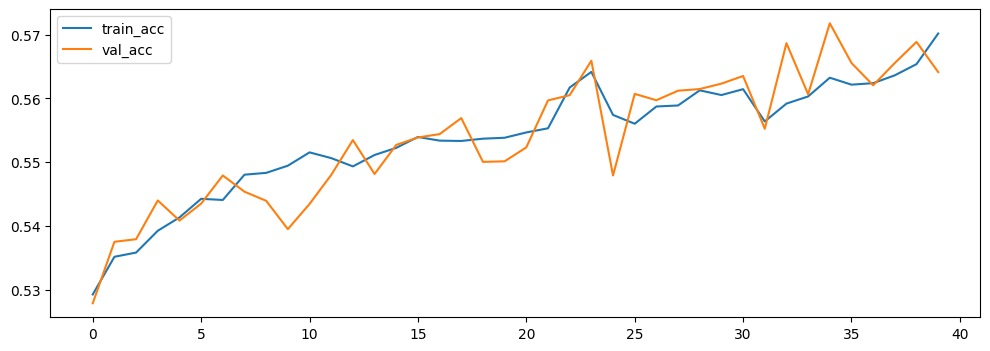

In [66]:
# 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(his.history['accuracy'], label='train_acc')
plt.plot(his.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [67]:
pred = model.predict(X_test_vec)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [68]:
pred

array([[0.43445054],
       [0.4051934 ],
       [0.41858596],
       ...,
       [0.42880237],
       [0.5506896 ],
       [0.6759807 ]], dtype=float32)

In [70]:
# 이진분류(sigmoid) -> 0.5를 기준으로 클래스 나누기
pred_cls = (pred > 0.5).astype('int')
pred_cls

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [72]:
y_test_sample = y_test.copy() # y_test의 복사본을 변수 sample로 만듦

In [73]:
y_test_sample = pd.DataFrame(y_test_sample) # 2차원 df로 만듦

In [74]:
y_test_sample['rnn_pred_cls'] = pred_cls # 'rnn_pred_cls' 컬럼 추가

In [75]:
y_test_sample # 실제답, rnn이 예측한 클래스 값 비교

,label,rnn_pred_cls
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
49995,1,0
49996,0,1
49997,0,0
49998,0,1


In [76]:
# 모델 전체 평가. X_test, y_test 기준
model.evaluate(X_test_vec, y_test)
# 학습 데이터 정확도 66%, 테스트 데이터 정확도 55%

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5560 - loss: 0.6617


[0.6625497341156006, 0.5554733276367188]

### SimpleRNN(바닐라RNN)의 경우 긴 시퀀스를 가진 데이터를 효과적으로 학습하기 어려움
- 순환횟수(시퀀스)가 길어질수록, 초반에 입력된 단어의 기억데이터가 소실되는 기울기 소실 현상이 발생함.
- 문장 구성 시 초반 단어가 후반 예측에 영향을 주는 경우, 바닐라RNN이 학습하기 어려움